# Predicting Hotel Cancellations

## 🏨 Background

You are supporting a hotel with a project aimed to increase revenue from their room bookings. They believe that they can use data science to help them reduce the number of cancellations. This is where you come in! 

They have asked you to use any appropriate methodology to identify what contributes to whether a booking will be fulfilled or cancelled. They intend to use the results of your work to reduce the chance someone cancels their booking.

## The Data

They have provided you with their bookings data in a file called `hotel_bookings.csv`, which contains the following:

| Column     | Description              |
|------------|--------------------------|
| `Booking_ID` | Unique identifier of the booking. |
| `no_of_adults` | The number of adults. |
| `no_of_children` | The number of children. |
| `no_of_weekend_nights` | Number of weekend nights (Saturday or Sunday). |
| `no_of_week_nights` | Number of week nights (Monday to Friday). |
| `type_of_meal_plan` | Type of meal plan included in the booking. |
| `required_car_parking_space` | Whether a car parking space is required. |
| `room_type_reserved` | The type of room reserved. |
| `lead_time` | Number of days before the arrival date the booking was made. |
| `arrival_year` | Year of arrival. |
| `arrival_month` | Month of arrival. |
| `arrival_date` | Date of the month for arrival. |
| `market_segment_type` | How the booking was made. |
| `repeated_guest` | Whether the guest has previously stayed at the hotel. |
| `no_of_previous_cancellations` | Number of previous cancellations. |
| `no_of_previous_bookings_not_canceled` | Number of previous bookings that were canceled. |
| `avg_price_per_room` | Average price per day of the booking. |
| `no_of_special_requests` | Count of special requests made as part of the booking. |
| `booking_status` | Whether the booking was cancelled or not. |

Source (data has been modified): https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

In [45]:
import pandas as pd
hotels = pd.read_csv("data/hotel_bookings.csv")
hotels

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not_Canceled
1,INN00002,2.0,0.0,2.0,3.0,Not Selected,0.0,Room_Type 1,5.0,2018.0,11.0,6.0,Online,0.0,0.0,0.0,106.68,1.0,Not_Canceled
2,INN00003,1.0,0.0,2.0,1.0,Meal Plan 1,0.0,Room_Type 1,1.0,2018.0,2.0,28.0,Online,0.0,0.0,0.0,60.00,0.0,Canceled
3,INN00004,2.0,0.0,0.0,2.0,Meal Plan 1,0.0,Room_Type 1,211.0,2018.0,5.0,20.0,Online,0.0,0.0,0.0,100.00,0.0,Canceled
4,INN00005,2.0,0.0,1.0,1.0,Not Selected,0.0,Room_Type 1,48.0,2018.0,4.0,11.0,Online,0.0,0.0,0.0,94.50,0.0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3.0,0.0,2.0,NaN,Meal Plan 1,0.0,NaN,85.0,2018.0,8.0,3.0,Online,NaN,0.0,0.0,167.80,1.0,Not_Canceled
36271,INN36272,2.0,0.0,1.0,3.0,Meal Plan 1,0.0,Room_Type 1,228.0,2018.0,10.0,17.0,Online,0.0,0.0,0.0,90.95,2.0,Canceled
36272,INN36273,2.0,0.0,2.0,6.0,Meal Plan 1,0.0,Room_Type 1,148.0,2018.0,7.0,1.0,Online,0.0,0.0,0.0,98.39,2.0,Not_Canceled
36273,INN36274,2.0,0.0,0.0,3.0,Not Selected,0.0,Room_Type 1,63.0,2018.0,4.0,21.0,Online,0.0,0.0,0.0,94.50,0.0,Canceled


## The Challenge

* Use your skills to produce recommendations for the hotel on what factors affect whether customers cancel their booking.

## _--- My analysis starts here ---_

# Data Cleaning
## Check data

I'll start by investigating the data and dealing with missingness in the dataframe.

In [46]:
import numpy as np

# total number of observations in original dataframe
no_obs_org = hotels.shape[0]

print(hotels.shape)

# create summary table of missingness
listsummary = []
for col in hotels.columns:
    missing_count = hotels[col].isna().sum()    
    row = {"col_name" :col,
           "dtype" :hotels[col].dtype,
            "missing" : missing_count,
            "missing %" : np.round(missing_count * 100/no_obs_org, 2),
          }
    listsummary.append(row)
missing_sum =  pd.DataFrame(listsummary)

#print summary of missingness for the dataframe
display(missing_sum)

(36275, 19)


,col_name,dtype,missing,missing %
0,Booking_ID,object,0,0.00
1,no_of_adults,float64,413,1.14
2,no_of_children,float64,324,0.89
3,no_of_weekend_nights,float64,367,1.01
4,no_of_week_nights,float64,807,2.22
5,type_of_meal_plan,object,526,1.45
6,required_car_parking_space,float64,2592,7.15
7,room_type_reserved,object,1171,3.23
8,lead_time,float64,472,1.30
9,arrival_year,float64,378,1.04


The dataframe consists of 36275 observations and 19 columns before cleaning. 

## Dealing with missingness

Most columns have missing values that account for less than 4% of the total observations. Let's see what will happen if I drop all the rows with missing values in these columns.

In [47]:
col_drop_list = list(missing_sum[missing_sum['missing %'] <= 4]['col_name'])
no_obs_dropna =hotels.dropna(subset=col_drop_list).shape[0]
no_obs_dropped = no_obs_org - no_obs_dropna
print('{} of {} rows will be dropped ({}%)'.format(no_obs_dropped, no_obs_org, np.round(no_obs_dropped * 100/no_obs_org, 2)))

6500 of 36275 rows will be dropped (17.92%)


Almost 18% of the data will be lost. That is a very large chunk of the data, so I will rather do some imputations where possible. 

Lets check for complete duplicates and bookings for which there is very little data available.


In [48]:
# print number of complete duplicates
print('Complete duplicates: {}\n'.format(hotels.duplicated().sum()))

# investigate missing values per row
missing_per_booking = hotels.isna().sum(axis = 1)
print(missing_per_booking.value_counts())

Complete duplicates: 0

0     27511
1      6052
2      1795
3       582
4       207
5        84
6        30
7         9
8         3
17        1
9         1
dtype: int64


There are no complete duplicates. Most bookings have a complete set of data, but some have a lot of missing values. One booking is missing 17 out of 19 values. I will drop all bookings with 5 or more missing values.

In [49]:
# drop observations with more than 5 missing values
hotels = hotels[missing_per_booking < 5]

Let's check the frequency tables of the columns with a small number of unique values to find appropriate imputations for each column.

In [50]:
col_list = hotels.columns.tolist()
for col in col_list:
    if hotels[col].nunique() < 8:
        print(col + ":")
        print(hotels[col].value_counts(normalize = True, dropna = False))
        print()

no_of_adults:
2.0    0.712867
1.0    0.210087
3.0    0.063269
NaN    0.009544
0.0    0.003790
4.0    0.000443
Name: no_of_adults, dtype: float64

no_of_children:
0.0     0.918333
1.0     0.044264
2.0     0.028910
NaN     0.007884
3.0     0.000526
9.0     0.000055
10.0    0.000028
Name: no_of_children, dtype: float64

type_of_meal_plan:
Meal Plan 1     0.756328
Not Selected    0.139652
Meal Plan 2     0.090077
NaN             0.013805
Meal Plan 3     0.000138
Name: type_of_meal_plan, dtype: float64

required_car_parking_space:
0.0    0.901486
NaN    0.069964
1.0    0.028550
Name: required_car_parking_space, dtype: float64

room_type_reserved:
Room_Type 1    0.751293
Room_Type 4    0.161231
NaN            0.031759
Room_Type 6    0.025894
Room_Type 2    0.018369
Room_Type 5    0.007055
Room_Type 7    0.004233
Room_Type 3    0.000166
Name: room_type_reserved, dtype: float64

arrival_year:
2018.0    0.812903
2017.0    0.177912
NaN       0.009185
Name: arrival_year, dtype: float64

market_se

For the columns `no_of_adults`, `no_of_children`,  `room_type_reserved` and `required_car_parking_space`, the modes make up more that 70% of that column's values. In these cases I will impute the mode of column for missing values.

The `no_of_special_requests`'s missing values will be imputed with 0, because if no special requests were captured in the data the client probably didn't have any.

The `type_of_meal_plan` column has a "Not Selected" option, which will be imputed for missing values.

A new category for `market_segment_type` will be created called "Unknown" for missing values.

For missing values for `repeated_guest`, 0 will be imputed if both `no_of_previous_cancellations` and `no_of_previous_bookings_not_canceled` are zero or missing, 1 be be imputed if either of these values are non-zero.

Bookings with missing values of the `arrival_year` will be dropped, as the.

In [51]:
# use the mode of the column to impute missing values if the mode accounts for more than 70% of the values in the column 
cols_fillna_mode = ['no_of_adults','no_of_children', 'required_car_parking_space', 'room_type_reserved']
for col in cols_fillna_mode:
    hotels[col].fillna(value = hotels[col].mode()[0], inplace = True) 

# use the mean for imputation for no_of_special_requests
hotels['no_of_special_requests'].fillna(value = 0, inplace = True)

# impute "Not Selected" for missing values in type_of_meal_plan
hotels['type_of_meal_plan'].fillna(value = 'Not Selected', inplace = True) 

# replace missing values in market_segment_type and room_type_reserved with "Unknown"
hotels['market_segment_type'].fillna(value = 'Unknown', inplace = True)

# number of with previous bookings
no_previous_bookings = hotels['no_of_previous_cancellations'] + hotels['no_of_previous_bookings_not_canceled']
no_previous_bookings_zero = (no_previous_bookings == 0)
# set missing repeated_guest to zero if there is zero previous bookings
hotels.loc[(hotels['repeated_guest'].isna()) & (no_previous_bookings_zero),'repeated_guest'] = 0
# set missing repeated_guest to one if there is previous bookings
hotels.loc[(hotels['repeated_guest'].isna()) & (~no_previous_bookings_zero), 'repeated_guest'] = 1

# drop bookings with no data for the arrival_month or arrival_year 
#no_month_or_year = (hotels['arrival_year'].isna()) | (hotels['arrival_month'].isna())
#hotels = hotels[~no_month_or_year]

The dataframe contains data from July 2017 to December 2018. If the arrival_month of a booking is June or before, missing values of arrival_year will be imputed with 2018. 

The distribution of bookings over `arrival_month` is not balanced in 2018 (the year for which we have a full set of data). There is no reliable way to infer the year or month for the rest of the missing values, so bookings with missing values for either `arrival_year` or `arrival_month` will be dropped.

In [52]:
# check date range of data
print(hotels['arrival_year'].unique())
print('First month in 2017: ', hotels[hotels['arrival_year'] == 2017]['arrival_month'].min())
print('Last month in 2018: ',hotels[hotels['arrival_year'] == 2018]['arrival_month'].max())
print('\n')

# print frequency table of months in 2018
print(hotels[hotels['arrival_year'] == 2018]['arrival_month'].value_counts(normalize=True))

# impute arrival_year with 2018 if arrival month is before July
hotels.loc[(hotels['arrival_year'].isna()) & (hotels['arrival_month'] < 7), 'arrival_year'] = 2018

# drop bookings with no data for the arrival_month or arrival_year 
no_month_or_year = (hotels['arrival_year'].isna()) | (hotels['arrival_month'].isna())
hotels = hotels[~no_month_or_year]

[2018. 2017.   nan]
First month in 2017:  7.0
Last month in 2018:  12.0


10.0    0.114336
6.0     0.107741
9.0     0.099739
8.0     0.094175
4.0     0.092046
5.0     0.087340
7.0     0.086035
3.0     0.079097
11.0    0.078376
12.0    0.070271
2.0     0.056773
1.0     0.034071
Name: arrival_month, dtype: float64


Let's check the distribution over days of the month to see if there is a general preference during the month for hotel stays.

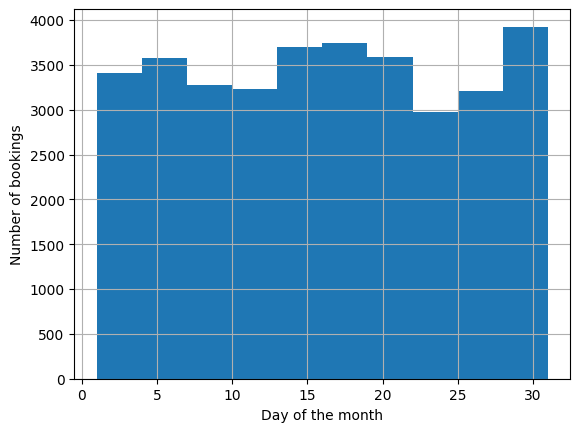

In [53]:
import matplotlib.pyplot as plt
hotels['arrival_date'].hist()
plt.xlabel('Day of the month')
plt.ylabel('Number of bookings')
plt.show()

The number of bookings are relatively stable throughout the days of the month. Therefore a random date will be imputed for missing dates. 

In [54]:
import random

# set random seed to be used throughout for reproducablity
SEED = 123
random.seed(SEED)

# number of days in each month
months_31_days = [1, 3, 5, 7, 8, 10, 12]
months_30_days = [4, 6, 9, 11]

# set random datefor missing arrival_date values
hotels.loc[(hotels['arrival_date'].isna()) & (hotels['arrival_month'].isin(months_31_days)), 'arrival_date'] = random.randint(1, 31)
hotels.loc[(hotels['arrival_date'].isna()) & (hotels['arrival_month'].isin(months_30_days)), 'arrival_date'] = random.randint(1, 30)

# neither 2017 nor 2018 were leap years
hotels.loc[(hotels['arrival_date'].isna()) & (hotels['arrival_month'] == 2), 'arrival_date'] = random.randint(1, 28)

Let's list the columns that still contain missing values we have to deal with.

In [55]:
for col in hotels.columns:
    if hotels[col].isna().sum() != 0:
        print(col)

no_of_weekend_nights
no_of_week_nights
lead_time
no_of_previous_cancellations
no_of_previous_bookings_not_canceled
avg_price_per_room


The `no_of_weekend_nights` and `no_of_week_nights` will be set to zero if it is missing. We will check for any inconsistencies this might create during data validation below.

The median of `lead_time` will be imputed as this represents a typical lead time.

In [56]:
# impute zero for missing values of  no_of_weekend_nights and no_of_week_nights
nights_cols = ['no_of_weekend_nights','no_of_week_nights']
for col in nights_cols:
    hotels[col].fillna(value = 0, inplace = True)

# impute typical lead time for missing values
hotels['lead_time'].fillna(value = hotels['lead_time'].median().round(), inplace = True)

Hotel prices can vary quite bit over the course of a year. Missing `avg_price_per_room` will be imputed with the average price for that room type in the year and month of arrival. However, if the `market_segment_type` is "Complementary", the average price will be set to zero.

In [57]:
# set missings values for avg_price_per_room equal to zero if market_segment_type is "Complementary"
hotels.loc[(hotels['avg_price_per_room'].isna()) & (hotels['market_segment_type'] == 'Complementary'), 'avg_price_per_room'] = 0

# fill missing values of avg_price_per_room with the average of the room type in that month and year
hotels['avg_price_per_room'] = hotels.groupby(['room_type_reserved','arrival_year','arrival_month'], sort=False)['avg_price_per_room'].transform(lambda x: x.fillna(x.mean()))

That only leaves us with the last two columns to deal with, `no_of_previous_cancellations` and `no_of_previous_bookings_not_canceled`. These features will most likely be very important in prediction if a booking will be cancelled, so I'd prefer not to impute anything. I will set both values to zero if the client is marked as not being a repeat guest and drop the observation if the client is a repeat guest with missing values in these two columns.

In [58]:
# set missing previous booking data to zero if not a repeat guest
prev_booking_cols = ['no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled']
for col in prev_booking_cols:
    hotels.loc[(hotels[col].isna()) & (hotels['repeated_guest'] == 0), col] = 0
    
# drop repeat guests with missing previous booking data
hotels = hotels.dropna(subset = prev_booking_cols)

# any missing values left?
hotels.isna().any()

Booking_ID                              False
no_of_adults                            False
no_of_children                          False
no_of_weekend_nights                    False
no_of_week_nights                       False
type_of_meal_plan                       False
required_car_parking_space              False
room_type_reserved                      False
lead_time                               False
arrival_year                            False
arrival_month                           False
arrival_date                            False
market_segment_type                     False
repeated_guest                          False
no_of_previous_cancellations            False
no_of_previous_bookings_not_canceled    False
avg_price_per_room                      False
no_of_special_requests                  False
booking_status                          False
dtype: bool

## Data validation

Let's investigate further to see if there are any bookings that don't make sense and should be removed.

I'll check if there are 
- any bookings where no people were booked
- any bookings with no weekday or weekend nights

In [59]:

# are there any bookings where no people were booked?
no_people = (hotels['no_of_adults'] == 0) & (hotels['no_of_children'] == 0)
print("Bookings with no people: {}".format(hotels[no_people]['Booking_ID'].count()))

# are there any bookings that does not last at leat one night?
no_nights = (hotels['no_of_weekend_nights'] == 0) & (hotels['no_of_week_nights'] == 0)
print("Bookings with no nights: {}".format(hotels[no_nights]['Booking_ID'].count()))

Bookings with no people: 2
Bookings with no nights: 453


The bookings with either no people or that did not least at leat 1 night will be removed.

In [60]:
hotels = hotels[~no_people]
hotels = hotels[~no_nights]

# final number of observations left in dataframe

no_obs_final = hotels.shape[0]
no_obs_dropped_final = no_obs_org - no_obs_final
print('Total observations removed from original dataset: {} ({}%)'.format(no_obs_dropped_final, np.round(no_obs_dropped_final / no_obs_org * 100, 2)))

Total observations removed from original dataset: 1179 (3.25%)


I only had to drop 3.3% of the original observations, which is acceptable. 

## Data type conversion

Now that the missing values have been dealt with, I will update some of the dtypes to more appropriate types. Of all the numerical columns, only the average price per room should be a float. The rest will be changed to integers.

The columns `type_of_meal_plan`, `room_type_reserved` and `market_segment_type` will be converted to categorical series.


In [61]:
# convert float columns to int
cols_to_int = hotels.select_dtypes('number').columns.tolist()
cols_to_int.remove('avg_price_per_room')
for col in cols_to_int:
    hotels[col] = hotels[col].astype('int')

# create categorical series where appropriate
hotels['type_of_meal_plan'] = pd.Categorical(hotels['type_of_meal_plan'], categories=['Meal Plan 1', 'Meal Plan 2', 'Meal Plan 3', 'Not Selected'], ordered=True)
hotels['room_type_reserved'] = pd.Categorical(hotels['room_type_reserved'], categories=['Room_Type 1', 'Room_Type 2', 'Room_Type 3','Room_Type 4', 'Room_Type 5', 'Room_Type 6', 'Room_Type 7', 'Unknown'], ordered=True)
hotels['market_segment_type'] = pd.Categorical(hotels['market_segment_type'], categories=['Online', 'Offline', 'Corporate', 'Aviation', 'Complementary', 'Unknown'], ordered=False)

hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35096 entries, 1 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   Booking_ID                            35096 non-null  object  
 1   no_of_adults                          35096 non-null  int64   
 2   no_of_children                        35096 non-null  int64   
 3   no_of_weekend_nights                  35096 non-null  int64   
 4   no_of_week_nights                     35096 non-null  int64   
 5   type_of_meal_plan                     35096 non-null  category
 6   required_car_parking_space            35096 non-null  int64   
 7   room_type_reserved                    35096 non-null  category
 8   lead_time                             35096 non-null  int64   
 9   arrival_year                          35096 non-null  int64   
 10  arrival_month                         35096 non-null  int64   
 11  ar

## New columns

I'll also add some new columns that might help with interpreting the data. First, some simple ones: 
- `no_of_people` will be the total number of people per booking
- `no_of_nights` will be the total number of nights booked
- `stay_type` will be 'Weekend only', 'Weekdays only' or 'Both' 
- `canceled` will be 1 if the booking was cancelled and 0 if otherwise


In [62]:
# create column with total number of peope per booking
hotels['no_of_people'] = hotels['no_of_adults'] + hotels['no_of_children']

# create column with total number of nights spent at the hotel per booking
hotels['no_of_nights'] = hotels['no_of_weekend_nights'] + hotels['no_of_week_nights']

# create conditions for no weekend / weekday nights
zero_weekend = (hotels['no_of_weekend_nights'] ==  0)
zero_weekdays = (hotels['no_of_week_nights'] == 0)

# categories to map to
stay_categories= ['Weekend only', 'Weekdays only'] 

# conditions per stay type
stay_conditions = [
    zero_weekdays, #weekend only
    zero_weekend, #weekdays only
    ]

# create categories from specified conditions
hotels['stay_type'] = np.select(stay_conditions, stay_categories, default="Both") 
hotels['stay_type'] = hotels['stay_type'].astype('category')

# create numerical column to indicate cancellations
mapping = {'Canceled':1, 'Not_Canceled':0}
hotels['canceled'] = hotels['booking_status'].replace(mapping)

I will also categorize the bookings by `traveler_type`. The categories will be created as follows:
- Single (1 adult)
- Couple (2 adults)
- Family (1-2 adults and children)
- Adult group (3 or more adults, no children)
- Family group (3 or more adults, and children)
- Children only (no adults)

In [63]:
# create various relevant conditions
no_kids = (hotels['no_of_children'] ==  0)
kids = (hotels['no_of_children'] > 0)
no_adults = one_adult = (hotels['no_of_adults'] ==  0)
one_adult = (hotels['no_of_adults'] ==  1)
two_adults = (hotels['no_of_adults'] ==  2)
group_adults = (hotels['no_of_adults'] >  2)

# categories to map to
type_categories= ['Single', 'Couple', 'Family', 'Adult group', 'Family group','Children only'] 

# conditions per type
type_conditions = [
    one_adult & no_kids, #single
    two_adults & no_kids, #couple
    (one_adult | two_adults) & kids, #family
    group_adults & no_kids, #adult group
    group_adults & kids, #family group
    no_adults & kids #children only
    ]

# create categories from specified conditions
hotels['traveler_type'] = np.select(type_conditions, type_categories, default="Other") 
hotels['traveler_type'] = hotels['traveler_type'].astype('category')

# inspect number of bookings per category
hotels['traveler_type'].value_counts()

Couple           23075
Single            7196
Family            2437
Adult group       2232
Children only      133
Family group        23
Name: traveler_type, dtype: int64

There is a number of bookings with only children. Presumably the adults accompanying them had a seperate booking. However, this group is very small and should not affect general conclusions.

A `date_of_arrival` column with a datetime object with the full date of arrival will also be added to the dataframe. 

In [64]:
# create column with date of arrival as datetime object
hotels['date_of_arrival'] = pd.to_datetime(dict(year = hotels['arrival_year'], month = hotels['arrival_month'], day=hotels['arrival_date']), errors='coerce')

# inspect entries where date converstion produced error
hotels[hotels['date_of_arrival'].isna()]

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,no_of_people,no_of_nights,stay_type,canceled,traveler_type,date_of_arrival
2626,INN02627,2,0,1,5,Meal Plan 1,0,Room_Type 1,104,2018,2,29,Online,1,1,0,61.43,0,Canceled,2,6,Both,1,Couple,NaT
3677,INN03678,1,0,1,3,Meal Plan 1,0,Room_Type 1,21,2018,2,29,Online,0,0,0,102.05,0,Canceled,1,4,Both,1,Single,NaT
5600,INN05601,2,0,1,3,Meal Plan 1,0,Room_Type 1,24,2018,2,29,Offline,0,0,0,45.50,0,Not_Canceled,2,4,Both,0,Couple,NaT
6343,INN06344,1,0,1,1,Meal Plan 1,0,Room_Type 1,117,2018,2,29,Offline,0,0,0,76.00,0,Not_Canceled,1,2,Both,0,Single,NaT
7648,INN07649,2,1,1,5,Meal Plan 1,0,Room_Type 1,35,2018,2,29,Online,0,0,0,98.10,1,Canceled,3,6,Both,1,Family,NaT
8000,INN08001,2,2,1,3,Meal Plan 1,0,Room_Type 6,3,2018,2,29,Online,0,0,0,183.00,1,Not_Canceled,4,4,Both,0,Family,NaT
8989,INN08990,1,0,1,2,Meal Plan 1,0,Room_Type 1,117,2018,2,29,Offline,0,0,0,76.00,0,Not_Canceled,1,3,Both,0,Single,NaT
9153,INN09154,2,2,1,3,Meal Plan 1,0,Room_Type 6,3,2018,2,29,Online,0,0,0,189.75,0,Not_Canceled,4,4,Both,0,Family,NaT
9245,INN09246,2,0,1,3,Meal Plan 1,0,Room_Type 4,15,2018,2,29,Online,0,0,0,85.55,1,Not_Canceled,2,4,Both,0,Couple,NaT
9664,INN09665,1,0,1,0,Meal Plan 1,0,Room_Type 4,21,2018,2,29,Online,0,0,0,117.00,0,Not_Canceled,1,1,Weekend only,0,Single,NaT


There appears to be a number of bookings for 29 February 2018. This was not a leap year, so this indicates an error in data. All these dates will be changed to 28 February 2018 and the datetime column will be generated again. 

In [65]:
# change all bookings for 29 Feb 2018 to 28 Feb 2018
hotels.loc[(hotels['arrival_year'] == 2018) & (hotels['arrival_month'] == 2) & (hotels['arrival_date'] == 29), 'arrival_date'] = 28

# create column with date of arrival as datetime object
hotels['date_of_arrival'] = pd.to_datetime(dict(year = hotels['arrival_year'], month = hotels['arrival_month'], day=hotels['arrival_date']))

# Exploring the data

## Cancelations over time

Let's see how the number of bookings and cancellations changed over time.

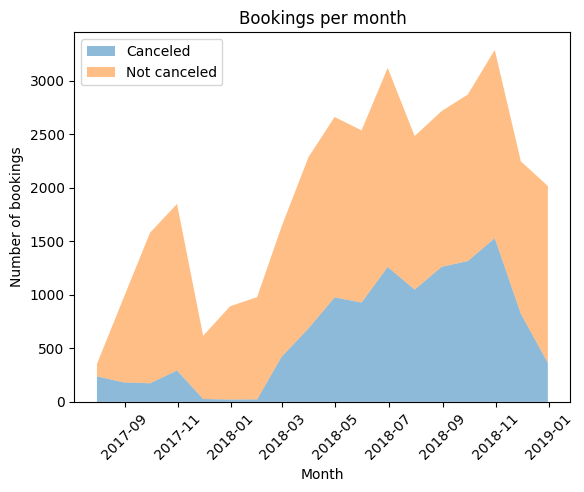

In [66]:
# create object that groups bookings per month and keeps track of the booking_status
bookings_per_month = hotels.reset_index().groupby('booking_status').resample('M', on= 'date_of_arrival')
no_bookings_per_month = pd.DataFrame(bookings_per_month['Booking_ID'].size()).reset_index()
no_bookings_per_month.set_axis(['booking_status', 'Month', 'Number_of_bookings'], axis=1, inplace=True)

# create table with number of canceled and not_canceled bookings per month
no_bookings_per_month = pd.pivot_table(no_bookings_per_month, values='Number_of_bookings', index='Month', columns=['booking_status'], aggfunc=np.sum).reset_index()

# plot the number of canceled and not_canceled bookings per month, stacked
labels = ['Canceled', 'Not canceled']
ax = plt.stackplot(no_bookings_per_month['Month'], no_bookings_per_month['Canceled'], no_bookings_per_month['Not_Canceled'] , alpha=0.5, labels = labels)
plt.legend(loc='upper left')
plt.xticks(rotation = 45)
plt.xlabel('Month')
plt.ylabel('Number of bookings')
plt.title('Bookings per month')
plt.show()

It appears that there as a big increase in canceled bookings during 2018. However, the total number of bookings also increased during this time, so this might not indicate an increase in the percentage of bookings that were canceled. It will makes sense to investigate the cancellation rate, or the ratio of cancelled bookings to total bookings over time. 



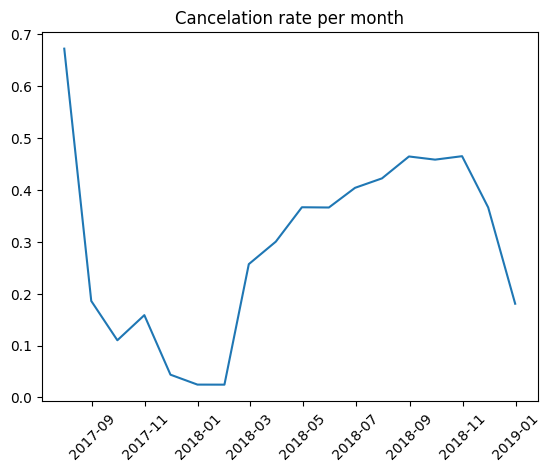

count    18.000000
mean      0.292793
std       0.181257
min       0.024540
25%       0.164051
50%       0.333147
75%       0.417674
max       0.672316
Name: cancelation_rate, dtype: float64

In [67]:
# create column with total number of bookings per month
no_bookings_per_month['total_bookings'] = no_bookings_per_month['Canceled'] + no_bookings_per_month['Not_Canceled']

# create colunm with cancelation rate per month
no_bookings_per_month['cancelation_rate'] = no_bookings_per_month['Canceled']/ no_bookings_per_month['total_bookings']

plt.plot(no_bookings_per_month['Month'], no_bookings_per_month['cancelation_rate'])
plt.xticks(rotation = 45)
plt.title('Cancelation rate per month')
plt.show()

no_bookings_per_month['cancelation_rate'].describe()

The cancelation rate averaged over each month in the data set varies significantlu over time (between 2% to 67%). A typical cancelation rate in a month is 33%.

## Effect of room price and type

Let's see if the average room price in a month affect whether or not a booking will be canceled.

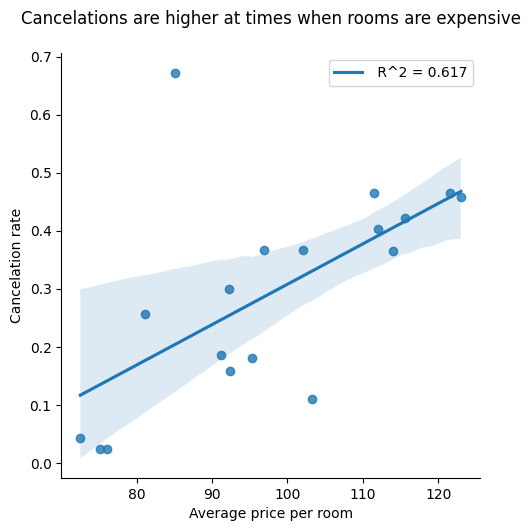

In [68]:
import seaborn as sns

# calculate the average room price per month
price_bookings_per_month = hotels.reset_index().resample('M', on= 'date_of_arrival')
price_bookings_per_month = pd.DataFrame(price_bookings_per_month['avg_price_per_room'].mean()).reset_index()

# plot the relationship between cancelation rate per month and average room price per month 
no_bookings_per_month['avg_price_per_room'] = price_bookings_per_month['avg_price_per_room']
corr_cancel_price = no_bookings_per_month['avg_price_per_room'].corr(no_bookings_per_month['cancelation_rate'])


ax = sns.lmplot(x = 'avg_price_per_room',y = 'cancelation_rate',data = no_bookings_per_month, line_kws={'label':" R^2 = {0:.3f}".format(corr_cancel_price)})
ax.set_xlabels('Average price per room')
ax.set_ylabels('Cancelation rate')
plt.title('Cancelations are higher at times when rooms are expensive',y = 1.05)
plt.legend(loc='best')
plt.show()

There is a strong positive correlation between the average monthly room price and the cancelation rate in that month. 

## Effect of types of travellers and group size
Let's explore whether cancelations relates to the type of travelers. 

In [69]:
# ratio of cancelations to total bookings averaged over all observations
avg_cancel_rate = hotels['canceled'].value_counts()[1] / no_obs_final

print('Average overall cancelation rate: {}\n'.format(np.round(avg_cancel_rate, 2)))

# define function to calculate cancelation rate of groups of observations
def cancel_ratio_per_group(col, df=hotels):
    """Gives number of cancelations per total number of bookings per groups in col
    
    Args:
        col (str): Name of column to group by 
        df (Optional): dataframe col is in, default = Hotels
          
    Returns:
        df: cancelation rate for each member in group
    """

    group_cancel = hotels.groupby(col)['canceled']
    group_cancel = pd.DataFrame(group_cancel.mean()).reset_index()

    # get number of bookings per group
    group_no_observations = pd.DataFrame(hotels[col].value_counts()).reset_index()
    group_no_observations.rename(columns = {'index': col, col:'no_of_bookings'}, inplace = True)
    
    # add no of bookings per group as column
    group_cancel = group_cancel.merge(group_no_observations, on = col)
   
    return group_cancel.rename(columns ={'canceled' : 'cancelation_rate'})

print(cancel_ratio_per_group('traveler_type').sort_values('cancelation_rate'))


Average overall cancelation rate: 0.33

   traveler_type  cancelation_rate  no_of_bookings
5         Single          0.241940            7196
4   Family group          0.260870              23
1  Children only          0.308271             133
2         Couple          0.347562           23075
0    Adult group          0.375000            2232
3         Family          0.378334            2437


Over the time of this dataset, the average cancelation rate is 33%. This is the same as the median cancelation rate averaged over a month.

**Single travelers seem to cancel the least often and Adult Groups and Families cancel the most often**. Family Groups also have a low cancelation rate. However, there are only 23 Family Groups in the dataset, so any results for that group might not be reliable. 

Does this indicate that smaller groups cancel less often than larger ones?

   no_of_people  cancelation_rate  no_of_bookings
0             1          0.241906            7197
1             2          0.346976           23284
2             3          0.364247            3720
3             4          0.440137             877
4             5          0.333333              15
5            10          0.000000               1
6            11          1.000000               1
7            12          0.000000               1


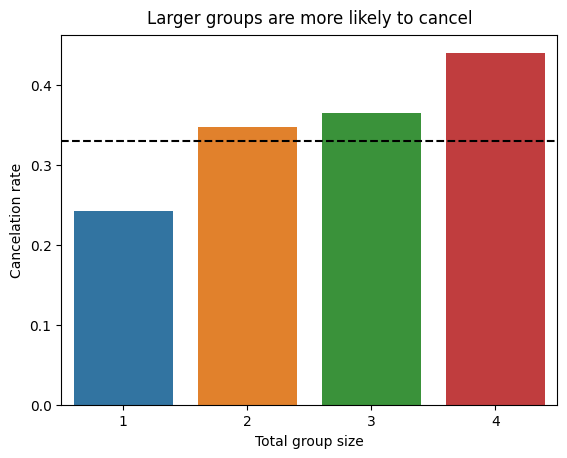

In [70]:
# get cancelation rate per group size
cancelrate_nopeople = cancel_ratio_per_group('no_of_people')
print(cancelrate_nopeople)

# check if there is at least 10 bookings for each group size
more_than_30_bookings = (cancelrate_nopeople['no_of_bookings'] >= 30)

#select only group sizes where there are at least 10 bookings
cancelrate_nopeople = cancelrate_nopeople[more_than_30_bookings]

# plot cancelation rate per group size
ax = sns.barplot(x='no_of_people',y='cancelation_rate',data=cancelrate_nopeople)
plt.axhline(y=avg_cancel_rate, color ='black',linestyle = '--')
plt.xlabel('Total group size')
plt.ylabel('Cancelation rate')
plt.title('Larger groups are more likely to cancel', y = 1.01)
plt.show()

The dashed line in the plot above indicates the overall average cancelation rate. 

There appears to be a trend that **larger groups are more likely to cancel than smaller groups**. 

## Effect of stay type and length of stay

Let's investigate the effects of stay type and length of say on the cancalation rate.

In [71]:
print(cancel_ratio_per_group('stay_type'))

       stay_type  cancelation_rate  no_of_bookings
0           Both          0.357985           16294
1  Weekdays only          0.304137           16269
2   Weekend only          0.310304            2533


Guests who only stay weekdays only have the lowest cancelation rate, followed by weekend-only stays. Stays that span both weekends and weekdays have a higher than average probablility of being canceled. With weekday stays having the lowest cancelation rate, together with the low rate of cancelations for single guests shown above, suggests that **people traveling for business purposes might be less likely to cancel compared to leisure travelers.**

The high cancelation rate of stays that span both weekdays and weekends might indicate that longer stays are more likely to be canceled. Let's check this.

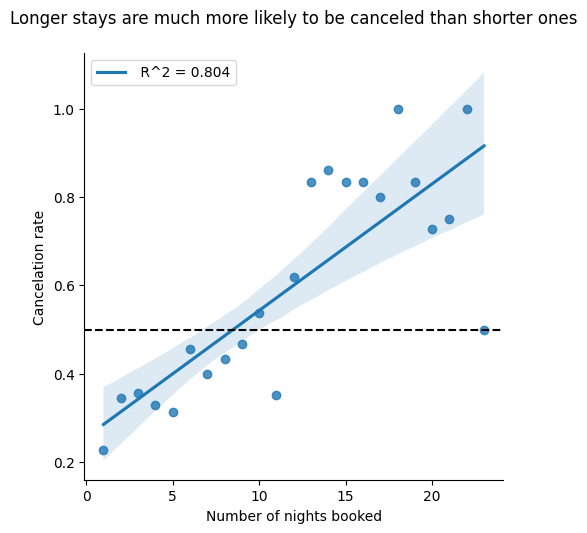

In [72]:
# find cancelation rates per total number of nights booked
no_nights_cancelations = cancel_ratio_per_group('no_of_nights')

# calculate correlation between total length of stay and cancelation rate
corr_cancel_nonights = no_nights_cancelations['no_of_nights'].corr(no_nights_cancelations['cancelation_rate'])

# plot the relationship between length of stay and cancelation rate
sns.lmplot(x='no_of_nights',y='cancelation_rate', data=no_nights_cancelations, line_kws = {'label':" R^2 = {0:.3f}".format(corr_cancel_nonights)})
plt.xlabel('Number of nights booked')
plt.ylabel('Cancelation rate')
plt.title('Longer stays are much more likely to be canceled than shorter ones', y = 1.05)
plt.legend(loc='upper left')
plt.axhline(y=0.5, color ='black', linestyle = '--')
plt.show()

The dashed line in the plot above indicates a 50% cancelation rate. Any bookings above this line will probably be canceled.

There is a very strong positive correlation between the total number of nights booked and the cancelation rate. The more nights someone has booked, the more likely they are to cancel the booking. In fact, stays that exceed 10 nights are more likely to be canceled than not canceled.

## Effect of market segment on cancelations
Let's see if there is a difference in cancelation rates between the market segments. 

  market_segment_type  cancelation_rate  no_of_bookings
0              Online          0.367215           21949
1             Offline          0.300331            9959
2           Corporate          0.106462            1888
3            Aviation          0.302521             119
4       Complementary          0.000000             350
5             Unknown          0.335740             831


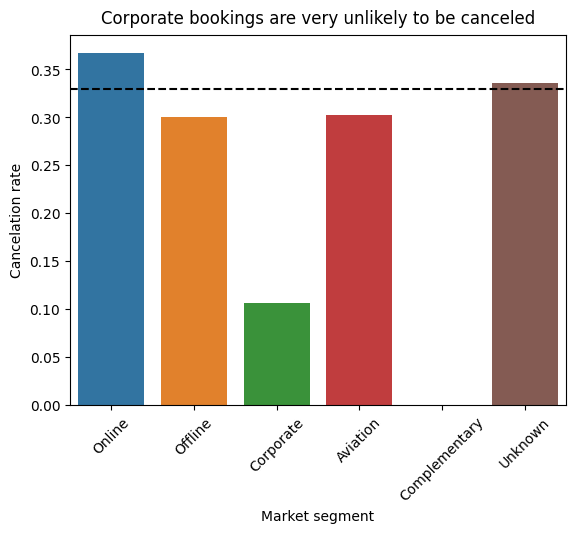

Corporate bookings are 3.1 times less likely to cancel bookings than average.


In [73]:
# get cancelation rate per market segment
cancelrate_market = cancel_ratio_per_group('market_segment_type')

print(cancelrate_market)

# plot cancelation rate per market segment
ax = sns.barplot(x='market_segment_type', y='cancelation_rate', data = cancelrate_market)
plt.axhline(y=avg_cancel_rate, color ='black',linestyle = '--')
plt.xlabel('Market segment')
plt.ylabel('Cancelation rate')
plt.title('Corporate bookings are very unlikely to be canceled', y = 1.01)
plt.xticks(rotation = 45)
plt.show()

cancelrate_corporate = cancelrate_market.loc[2, 'cancelation_rate']

print('Corporate bookings are {} times less likely to cancel bookings than average.'.format(np.round(avg_cancel_rate/cancelrate_corporate, 1)))

**Corporate bookings are very unlikely to be canceled, and is canceled 3 times less than average**. This is futher evidence that business travelers are less likely to cancel than leisure travelers. Online bookings are more likely than average to be canceled and this segment also accounts for about half of all bookings. Interventions to reduce cancelations for the Online segment can be very impactful. Complementary bookings are never canceled.

## Behaviour of repeat guests

Let's see if there is a difference between repeat guests and guests that book for the first time.

In [74]:
print(cancel_ratio_per_group('repeated_guest'))

   repeated_guest  cancelation_rate  no_of_bookings
0               0          0.337640           34214
1               1          0.017007             882


Repeat guests cancel far less than new guests. However, there are also not a lot of repeat guests in the data set. Let's investigate this further.

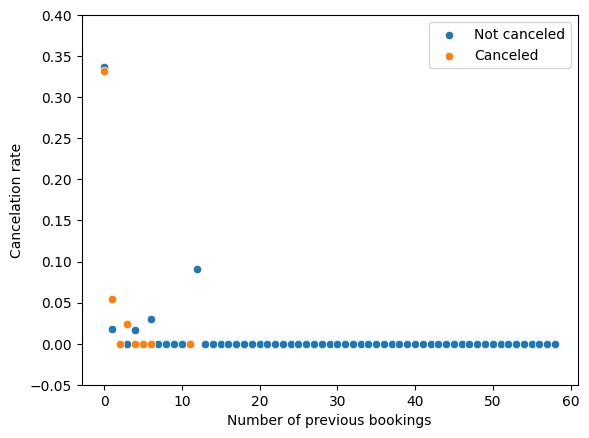

In [75]:
# select repeat guests from data set
repeat_guests = hotels[hotels['repeated_guest'] == 1]

# calculate cancelation rates for repeat guests based on there previous cancelations
cancel_history = cancel_ratio_per_group('no_of_previous_cancellations',df = repeat_guests)
no_cancel_history = cancel_ratio_per_group('no_of_previous_bookings_not_canceled',df = repeat_guests)


ax = sns.scatterplot(x='no_of_previous_bookings_not_canceled',y='cancelation_rate',
                data=no_cancel_history, label = 'Not canceled')

sns.scatterplot(x='no_of_previous_cancellations',y='cancelation_rate',
                data=cancel_history, ax = ax, label = 'Canceled')
plt.legend()
plt.ylim(None, 0.4)
plt.xlabel('Number of previous bookings')
plt.ylabel('Cancelation rate')
plt.show()

Surprisingly, the number of previous cancelations does not generally increase the chance of someone canceling a current booking. **Repeat customers are far more likely than average not to cancel bookings, even if they have canceled in the past**.

## Effect of special requests
Let's see if the number of special requests has any effect on whether or not a booking will be canceled.

   no_of_special_requests  cancelation_rate  no_of_bookings
0                       0          0.431166           19489
1                       1          0.237546           10760
2                       2          0.146966            4137
3                       3          0.000000             626
4                       4          0.000000              76
5                       5          0.000000               8


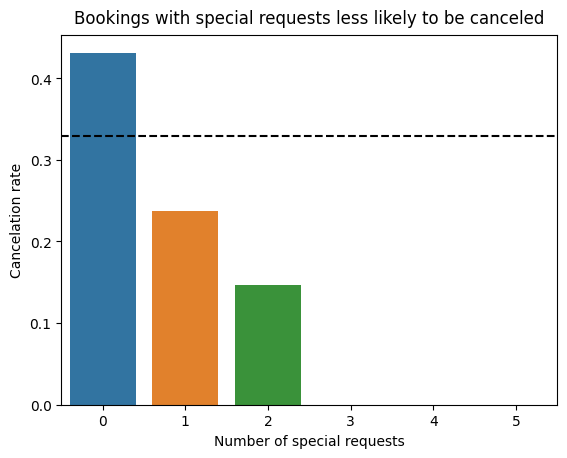

In [76]:
# get cancelation rate per number of special requests
cancelrate_requests = cancel_ratio_per_group('no_of_special_requests')

print(cancelrate_requests)

# plot cancelation rate per number of special requests
ax = sns.barplot(x='no_of_special_requests', y='cancelation_rate', data = cancelrate_requests)
plt.axhline(y=avg_cancel_rate, color ='black',linestyle = '--')
plt.xlabel('Number of special requests')
plt.ylabel('Cancelation rate')
plt.title('Bookings with special requests less likely to be canceled', y = 1.01)
plt.show()


Cancellations decrease significantly as the number of special requests increase. It is difficult to interpret this, as the cause of this trend is unknown. 

## The effect of lead time

Hotels often give discounts for bookings made far in advance. Let's see if these bookings are more or less likely to be canceled.

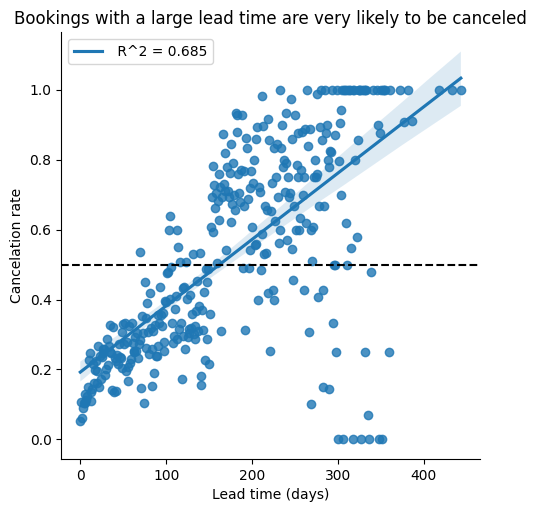

In [77]:
# calculate cancelation rate per lead time
lead_time_cancelations = cancel_ratio_per_group('lead_time')

# get correlation coefficient between lead time and cancelation rate
corr_cancel_leadtime = lead_time_cancelations['lead_time'].corr(lead_time_cancelations['cancelation_rate'])

sns.lmplot(x='lead_time',y='cancelation_rate', data=lead_time_cancelations, line_kws = {'label':" R^2 = {0:.3f}".format(corr_cancel_leadtime)})
plt.xlabel('Lead time (days)')
plt.ylabel('Cancelation rate')
plt.title('Bookings with a large lead time are very likely to be canceled')
plt.legend(loc='upper left')
plt.axhline(y=0.5, color ='black', linestyle = '--')
plt.show()

There is a strong positive relationship between lead time and cancellation rate. **Bookings made more than 5 months in advance are more likely to be canceled than not canceled**.

# Summary of results

To investigate the cancelations of bookings at the hotel, the cancelation rate (number of canceled bookings per total bookings) was used as a metric. The cancelation rate per month over the 18 months available in the dataset varies significantly per month, with a minimum of 2% and a maximum of 67%. The overall average cancelation rate, as well as the typical cancelation rate per month is 33%. 

The cancelation rate for different types of bookings and guests were examined. The groups that are the least likely to cancel their bookings have the following attributes:
- Single travelers
- Short stays
- Weekday stays
- Corporate bookings
- Short lead times
- Repeat customers

The bookings that are most likely to be canceled are bookings that have
- Large groups
- Long stays
- Booked online
- Booked far in advance

Let's great some profiles of guests and see if these results hold up. We'll create a profile for

**Business traveler**
- Single traveler
- Stay less or equal to 3 nights
- Weekdays only

**Group holiday**
- Group of 4 or more people
- Stay of 4 or more nights

**Couples weekend getaway**
- Two adults
- Weekend only

In all cases a short lead time will be considered 30 days or less, and a long lead time 30+ days.


If the interpretation of the results are correct, we expect business travelers to have a very low general cancelation rate. Even with a long lead time, these bookings should still come below average.

Group hollidays will have the hightest cancelation rate, far above the 33% average. Group holidays with short lead times is expected to have a lower cancelation rate that the long lead time counterpart, but should still be higher than average. 

Couples on a weekend getaway should have an overall cancelation rate close to the overall average, with those with short lead times coming in below 33% and those with long lead times above. 


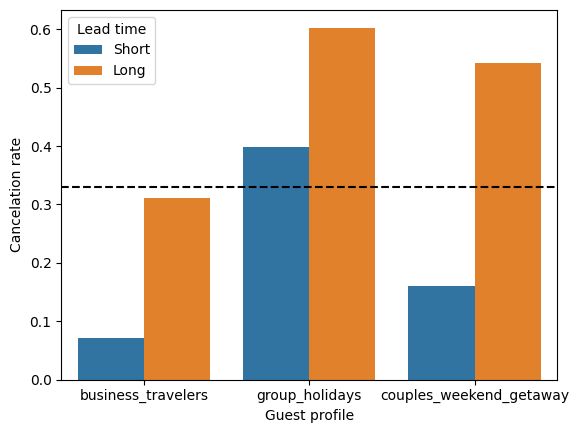

In [78]:
profiles = {}

# define short and long lead times
short_lead = (hotels['lead_time'] <= 30)
long_lead = (hotels['lead_time'] > 30)

# conditions for business travelers
singles = (hotels['traveler_type'] == 'Single')
short_stays = (hotels['no_of_nights'] <= 3) 
weekdays_only = (hotels['stay_type'] == 'Weekdays only')
business_cond = (singles & short_stays & weekdays_only)

# get cancelation rates for business travelers
profiles['business_travelers'] = [hotels[business_cond & short_lead]['canceled'].mean(), hotels[business_cond & long_lead]['canceled'].mean()]

# conditions for group holidays
large_groups = (hotels['no_of_people'] >= 4)
long_stays = (hotels['no_of_nights'] >= 4) 

# get cancelation rates for group holiday travelers
profiles['group_holidays'] = [hotels[large_groups & long_stays & short_lead]['canceled'].mean(), hotels[large_groups & long_stays & long_lead]['canceled'].mean()]

# conditions for couples' weekend getaway
couples = (hotels['traveler_type'] == 'Couple')
weekend_only = (hotels['stay_type'] == 'Weekend only')

# get cancelation rates for couples' weekend getaway
profiles['couples_weekend_getaway'] = [hotels[couples & weekend_only & short_lead]['canceled'].mean(), hotels[couples & weekend_only & long_lead]['canceled'].mean()]

# prepare data for visualization
profiles = pd.DataFrame(profiles, index = ['Short', 'Long'])
profiles = profiles.transpose().reset_index()
profiles = pd.melt(profiles, id_vars='index', value_vars=['Short', 'Long'], var_name='Lead time', value_name= 'Cancelation rate')

# plot cancelation rates of profiles
ax = sns.barplot(x='index', y='Cancelation rate', hue = 'Lead time', data = profiles)
plt.axhline(y=avg_cancel_rate, color ='black',linestyle = '--')
plt.xlabel('Guest profile')
plt.ylabel('Cancelation rate')
plt.show()

# Main recommendations

Based on the analysis above, my main recommendations to the hotel to reduce the cancelation rate are:

**Business travelers are the most reliable type of traveler:**
Target marketing towards business travelers and businesses that can create corporate booking accounts

**Build relationships with guests:** 
Encourage repeat guests through loyalty programmes and rewards.

**Bookings made far in advance will most likely be canceled:**
Limit the lead time of bookings to no more than 6 months in advance. Do not offer early-bird discounts and incentives.

**Longer stays will likely be canceled:**
Do not offer long-stay discounts, rather invest in benefits for repeat guests.

**Online bookings are the largest segment, but also most likely to cancel**
Reducing the cancelation rate of the online segment will have the largest impact on cancelations. Inverventions like marketing last-minute deals and having stricter cancelation policies for this segment may decrease cancelations. It is also possible that the inpersonal nature of the online booking system makes it easier to cancel. Personalized communication from the hotel to online guests after booking might 

# Predicting cancelations 

In order to help the hotel manage their bookings, it will help them to be able to predict whether or not any particular booking will be canceled. This will be helpful when planning the number of staff members that has to be present, targeted inverventions to prevent guest from canceling their bookings and managing their overbooking policy. I will create a binary classification model to this end. 

## Preparing the data for machine learning

The numerical column `canceled` will be the target variable, the feature `booking_status` that contains the same information will be dropped I will remove the rest of the columns that I added to the data, as they contain duplicated information that is present in the original features. I will remove Booking_ID, as this is a unique value for each booking. 

I will also remove `required_car_parking_space` and `type_of_meal_plan`. Only 3% of bookings required a parking space, so this feature will probably just introduce noise in the model. It is unclear how meal plans are chosen and this feature is most likely highly correlated with the room type and the price. It is also highly unlikely that a parking space or meal type reservation has a significant effect on wheather a booking will be canceled or not. 

We alread saw above that `no_of_previous_cancellations` and `no_of_previous_bookings_not_canceled` have very little effect on whether or not a current booking will be canceled. These features also only apply to a small percentage of bookings (repeat guests), so they will be removed as noise.

In [81]:
# define target variable
y = hotels['canceled']

# columns to drop from features
cols_to_drop = ['Booking_ID', 'type_of_meal_plan', 'required_car_parking_space',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'booking_status',
       'no_of_people', 'no_of_nights', 'stay_type', 'canceled',
       'traveler_type', 'date_of_arrival']

# define features for ML model 
X = hotels.drop(columns = cols_to_drop)

I create dummy variables to represent the categorical data in the features and split the data in to 80% training and 20% test sets so that model preformance can be measured. I will also scale the data.

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# convert categorical variables to numerical types
X = pd.get_dummies(X, drop_first = True)

# split data into 20% testing and 80% training sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, stratify = y, random_state = SEED)

# scale the data 
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

To select an appropriate model, I will do cross-validation on three types of classifiation models with the default parameters. This will give an indication which kind of model is best-suited for this problem. Because the value of interest is to predict if a booking will be canceled, I will use the F1 score to evaluate model performance. A F1 score can vary between 0 and 1, where a value of 1 indicates a model that makes perfect predictions.

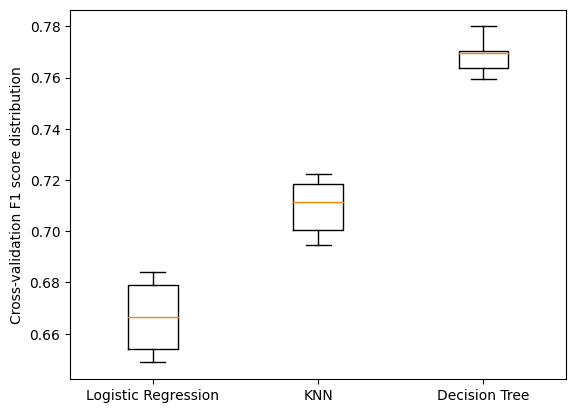

Logistic Regression Test Set F1 score: 0.659
KNN Test Set F1 score: 0.73
Decision Tree Test Set F1 score: 0.786


In [83]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import f1_score

# define classifiers to test
models = {"Logistic Regression": LogisticRegression(), "KNN": KNeighborsClassifier(n_neighbors = 2), "Decision Tree": DecisionTreeClassifier()}

# do cross-validation on each type of model to evaluate performance
results = []
for model in models.values():
     kf = KFold(n_splits=6, random_state=SEED, shuffle=True)
     cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring = 'f1') 
     results.append(cv_results)

# plot the cross-validation results
plt.boxplot(results, labels=models.keys())
plt.ylabel('Cross-validation F1 score distribution')
plt.show()

# print the F1 score of the test set for each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    test_score = f1_score(y_test, y_pred)
    print("{} test set F1 score: {}".format(name, np.round(test_score,3)))

The classification tree performs the best overall, and also has the lowest variance. I will see if we can get improvement in the F1 score by using Random Forest ensamble method. Desicion trees are not sensitive to unscaled data, so I will use the unscaled feature sets. 

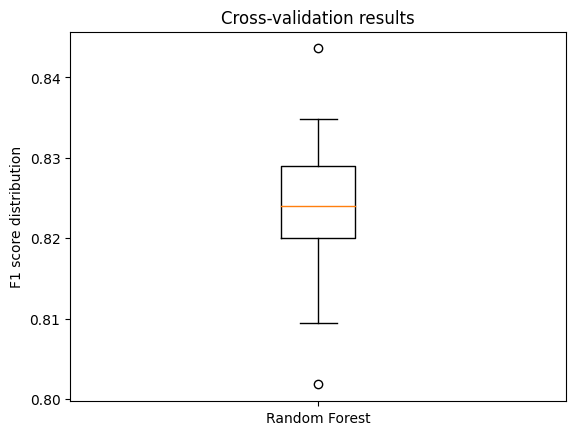

Random Forest test set F1 score: 0.834


In [92]:
from sklearn.ensemble import RandomForestClassifier

# instansiate random forest classifier
rf = RandomForestClassifier(random_state=SEED)

rf_kf = KFold(n_splits=10, random_state=SEED, shuffle=True)
rf_cv_results = cross_val_score(rf, X_train, y_train, cv=rf_kf, scoring = 'f1') 

# plot the cross-validation results
plt.boxplot(rf_cv_results, labels=['Random Forest'])
plt.ylabel('F1 score distribution')
plt.title('Cross-validation results')
plt.show()
     
# fit the training sets
rf.fit(X_train, y_train)

# predict classes of test set
y_pred_rf = rf.predict(X_test)

# print random forest F1 score
print('Random Forest test set F1 score:',np.round(f1_score(y_test, y_pred_rf),3))


Using the Random Forest with default parameters instead of the Decision Tree has increased the F1 score calculated on the test set by 6% to 0.834. Finally, I will look at the confusion matrix of the test set predictions. 

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      4706
           1       0.87      0.80      0.83      2314

    accuracy                           0.89      7020
   macro avg       0.89      0.87      0.88      7020
weighted avg       0.89      0.89      0.89      7020



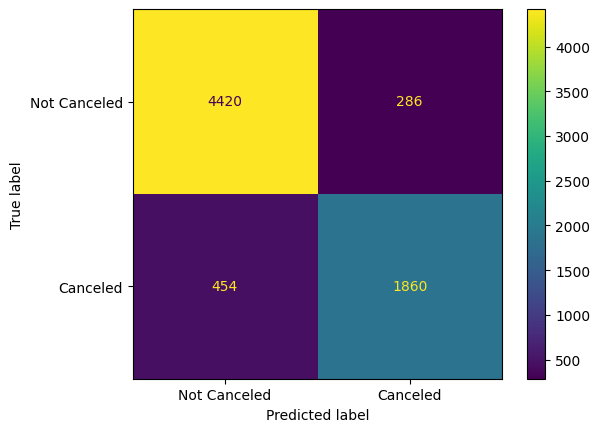

In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# print classification report
print(classification_report(y_test, y_pred_rf))

# calculate and display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['Not Canceled', 'Canceled']).plot()

plt.show()

The model performs well and has high recall and precision for both classes. It is better at predicting  when a booking  will not be canceled, than when it will be canceled.